# Development notebook for processing sexual dimorphism data
## This notebook takes as input the csv produced from 'sample_reader_nb', which represents the load and rearranged sexual dimorphism data matrix

In [1030]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE

import dimorph_processing as dp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read in meta data and big data file, create meta_data_df, and remove cntnp strain

In [2]:
meta_data_df, dimorph_df, dimorph_df_bool = dp.load_data(metadata_file = '/bigdata/isaac/meta_data_dict_040224.json', 
                                                         bigdata_file = '/bigdata/isaac/dimorph_df.feather')

In [3]:
dimorph_df.shape

(27933, 79613)

In [4]:
meta_data_df.shape

(27, 79613)

In [1024]:
meta_data_df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
Serial_Number,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
Date_Captured,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,...,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,...,,,,,,,,,,


In [1025]:
## TODO add metadata updating (intialize all the upcoming processsing steps as none, 
## update at each step in metadata) and boolean write to file for each processing step for metadatadf and gene expression df

#### create boolean version of gene expression data frame, used in level 2 and level 3 filtering

In [5]:
# create boolean version of the dataframe, where any expression >0 = 1,
# used to calculate total genes/cell
#dimorph_df_bool = dimorph_df.mask(dimorph_df>0, other = 1)
dimorph_df_bool.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,1,0,1,0,0,1,1,1,0,...,1,0,1,0,1,1,1,0,0,0
0610009B22Rik,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
0610009L18Rik,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
0610009O20Rik,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610010F05Rik,0,0,1,0,0,0,1,1,1,0,...,1,0,1,0,1,0,1,0,0,0


### 2. Calculate molecules/cell and genes/cell vectors, keep only cells with >2500 mol/cell and >2000 genes/cell

In [6]:
dimorph_df_l2, dimorph_df_bool_l2, meta_data_df_l2 = dp.cell_exclusion(threshold_m = 2500, 
                                                      threshold_g = 2000,
                                                      df_bool = dimorph_df_bool,
                                                      meta_data_df = meta_data_df,
                                                      df = dimorph_df)
dimorph_df_l2.head()

Total cells reduced from 79613 to 43492


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [7]:
dimorph_df_l2.shape

(27933, 43492)

### 3. Gene Exclusion - Keep only genes expressed in >10 cells, <50% of all cells

In [8]:
dimorph_df_l3, dimorph_df_bool_l3, meta_data_df_l3 = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=dimorph_df_bool_l2,
                                                     df = dimorph_df_l2,
                                                     meta_data_df = meta_data_df_l2)
dimorph_df_l3.head()

Total genes reduced from 27933 to 17081


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [9]:
dimorph_df_l3.shape

(17081, 43492)

#### Sanity Check if known sex specific genes in dimorph_df_l2

In [10]:
print ('Xist' in dimorph_df_l2.index)
print ('Tsix' in dimorph_df_l2.index)
print ('Ddx3y' in dimorph_df_l2.index)
print ('Eif2s3y' in dimorph_df_l2.index)
print ('Kdm5d' in dimorph_df_l2.index)
print ('Uty' in dimorph_df_l2.index)

True
True
True
True
True
True


num m cells: 19749 num f cells: 23743


<IPython.core.display.Javascript object>


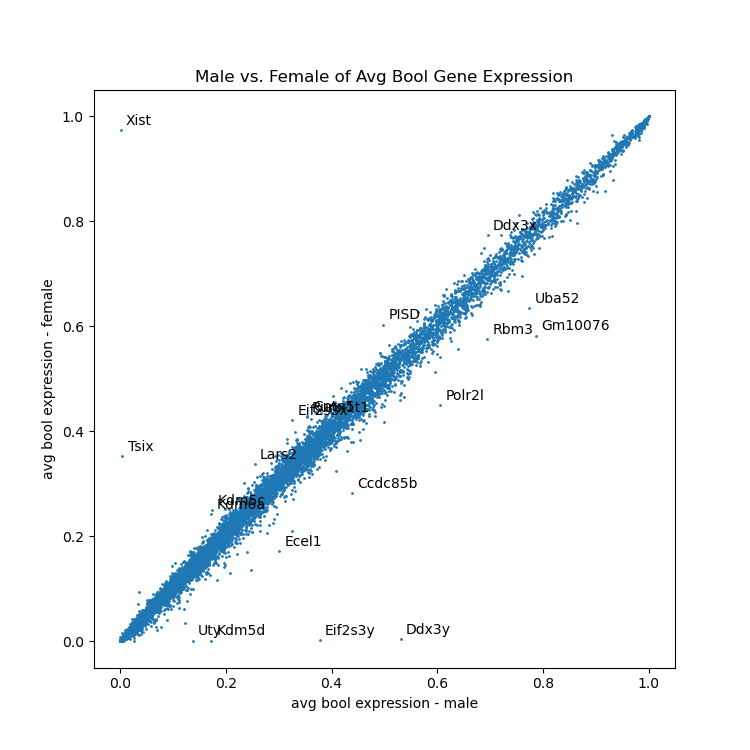

In [11]:
%matplotlib notebook
avg_bool_mf_df_sorted_l2 = dp.avg_bool_gene_expression_by_sex(df_bool = dimorph_df_bool_l2,
                                                              meta_data_df=meta_data_df_l2,
                                                             num_top_genes=10,
                                                             plot_flag=1)

### 4. CV vs. Mean (Poisson filter)

(17081, 1)
(17081,)
(17081, 1)


<IPython.core.display.Javascript object>


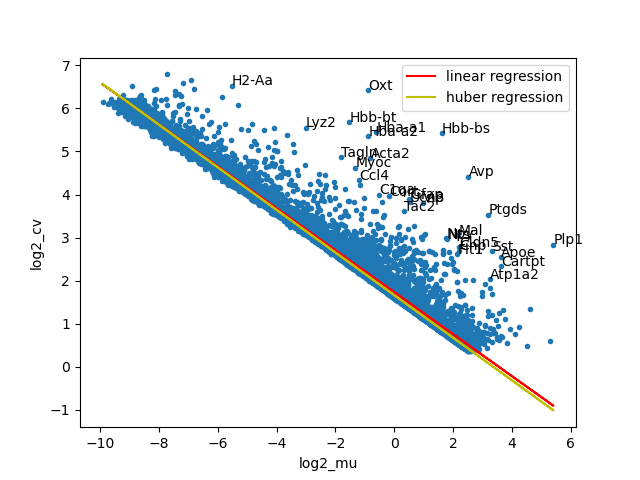

In [413]:
cv_df = dp.analyze_cv(df = dimorph_df_l3,
                      norm_scale_factor=20000,
                      num_top_genes=30,
                      plot_flag=1,
                     use_huber = True)

In [414]:
cv_df.head()

,log2mu,log2cv,delta_cv
gene,,,
Hbb-bs,1.620289,5.429946,4.570352
Oxt,-0.879842,6.428204,4.330631
Avp,2.526425,4.414903,4.003995
Plp1,5.415903,2.831623,3.851485
Hba-a1,-0.615138,5.448019,3.481519


In [415]:
dimorph_df_l3.shape

(17081, 43492)

In [416]:
cv_df.shape

(17081, 3)

#### knee plot

<IPython.core.display.Javascript object>


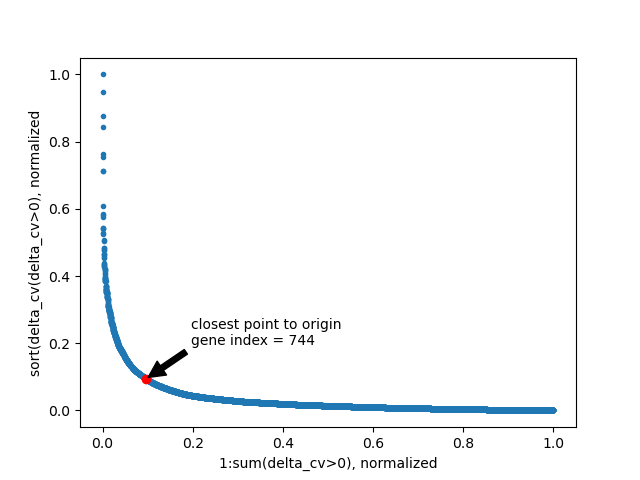

In [889]:
gene_index, dimorph_df_l4 = dp.get_top_cv_genes(df = dimorph_df_l3, cv_df=cv_df, plot_flag=1)

In [890]:
dimorph_df_l4.shape

(744, 43492)

In [624]:
gene_index

744

##### Feature selection 
utilize mean-variance relationship (PCA). Why this as opposed t mean-dropout relationship? see 'feature selection' section in :
https://www.nature.com/articles/s41467-019-13056-x

In [888]:
dimorph_df_l4.shape

(744, 43492)

In [891]:
dimorph_df_l4.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oxt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Avp,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Plp1,0,0,2,0,0,0,1,0,0,0,...,1,0,0,1,0,71,0,0,0,1
Hba-a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [900]:
log_std_arr = dp.log_and_standerdize_df(dimorph_df_l4)

row mean after standardization: 0.00
row sigma after standardization: 1.00


In [901]:
log_std_arr.shape

(43492, 744)

PCA with num components = all genes 

<IPython.core.display.Javascript object>


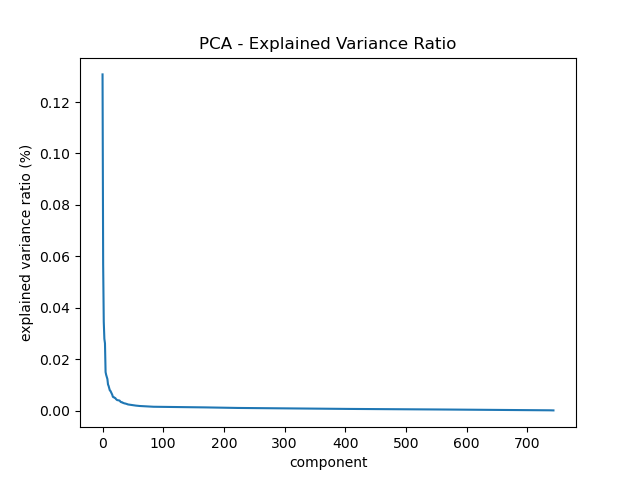

/home/isaac/analysis/scRNA-seq/dimorph_processing.py:265: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  l = ax.scatter(component_list_n,variance_ratio_n, marker = '.')


<IPython.core.display.Javascript object>


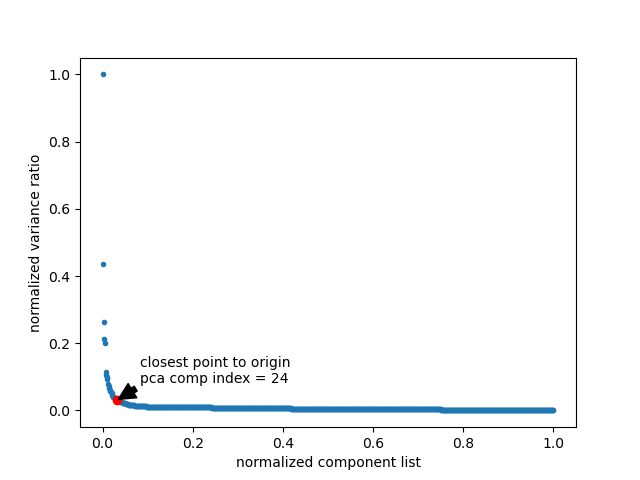

<IPython.core.display.Javascript object>


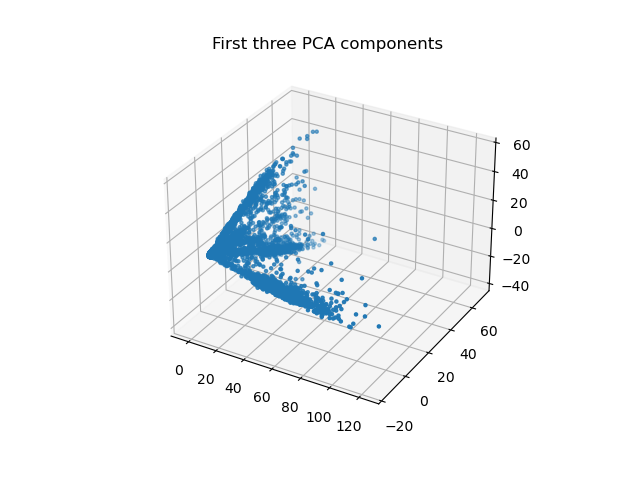

In [919]:
pca_index, arr_pca = dp.analyze_pca(arr = log_std_arr, n_components=log_std_arr.shape[1], plot_flag=1)

In [912]:
arr_pca.shape

(43492, 24)

In [911]:
pca_index

24

Amit's method for determining perplexity param - 
1) compute pairwise distance matrix (n_cells x n_cells) from PCA reduced matrix.
2) sort columns by ascending values
3) compute angle from first point to last point of column values from index 1-500
4) use rotation matrix to rotate column values by this angle
5) take argmax for each rotated set of column values and store in list
6) take median of list created in step 5, this is perplexity value



<IPython.core.display.Javascript object>


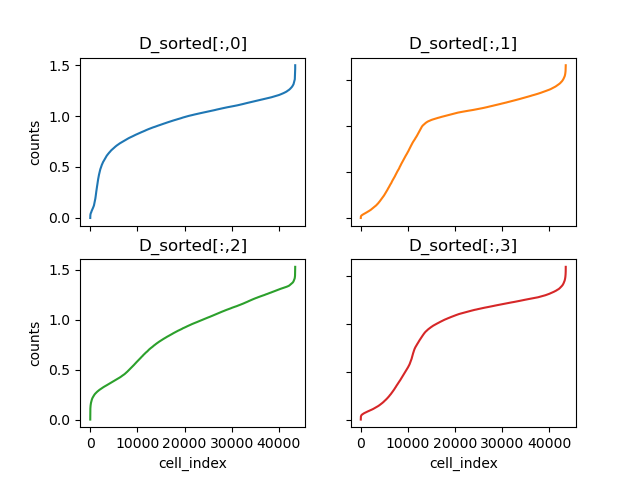

<IPython.core.display.Javascript object>


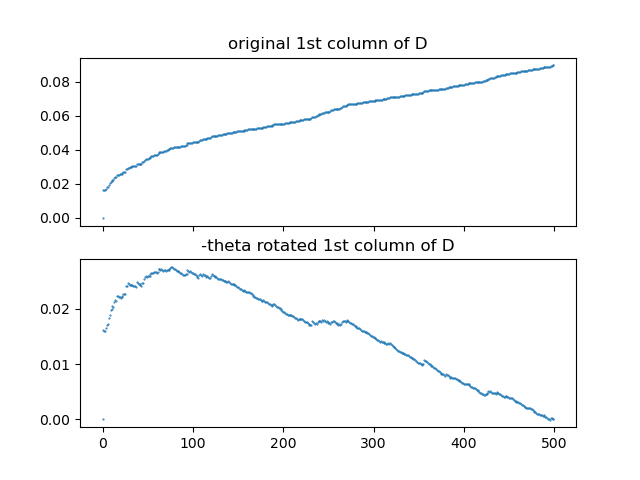

In [1023]:
perplexity = dp.get_perplexity(pca_arr = arr_pca, cutoff=500, plot_flag=1)

In [1026]:
perplexity

57.0

creating tsne object with the following parameters: 
n_components:2
n_iter: 1000
learning_rate: 50
early_exaggeration: 12
init: pca
perplexity: 57.0


<IPython.core.display.Javascript object>


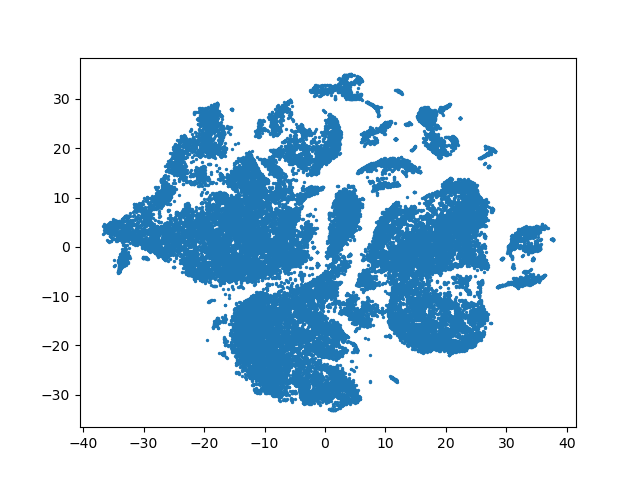

In [1034]:
dp.do_tsne(arr = arr_pca, 
           n_components=2,
           n_iter=1000,
           learning_rate=50,
           early_exaggeration=12,
           init='pca', 
           perplexity = perplexity)